In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/Shareddrives/CSCI 461/processed'
#%ls processed/*

data = pd.read_csv("combined_ohe_17.csv") # only 17 yr olds

Mounted at /content/drive/
/content/drive/Shareddrives/CSCI 461/processed


In [ ]:
# fixing education 

edu_matrix = data[["highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license"]]
data["edu_categorical"] = edu_matrix.idxmax(axis=1)

educationBinary = \
{   
    "highedcert_associate degree": 1,
    "highedcert_bachelor degree": 1,
    "highedcert_high school or ged": 1,
    "highedcert_higher degree": 1,
    "highedcert_none of the above":0,
    "highedcert_vocational certificate": 1,
    "highedcert_vocational license": 1
}
data['edu_binary'] = data["edu_categorical"].map(educationBinary) 

#target
target='subabuse_yes'
data.drop(columns=["age"], inplace=True)
data.drop(columns=["recnumbr", "highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license","edu_categorical", 'currpte_yes', 'currpte_no','currfte_yes', 
                   'currfte_no', 'edu_binary','homeless_no','homeless_yes', 'subabuse_no', 'incarc_no', 'incarc_yes', 'edu_categorical'], axis=1, inplace=True)

In [ ]:
#balancing?
k=5
y = data.loc[:,target]
X = data.loc[:,data.columns != target]
X=X.reset_index(drop=True)
smote_enn = SMOTEENN(random_state=0)
X, y = smote_enn.fit_resample(X, y)

In [ ]:
#stratification of balanced dataset
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
#data['target'] IS THE VARIABLE USED FOR STRATIFIED SAMPLING.
splits = kfold.split(X,y)
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{y.value_counts() / len(y)}\n\n')
for n,(train_index,test_index) in enumerate(splits):
    print(f'SPLIT NO {n+1}\nTRAINING SET SIZE: {np.round(len(train_index) / (len(train_index)+len(test_index)),2)}'+
          f'\tTEST SET SIZE: {np.round(len(test_index) / (len(train_index)+len(test_index)),2)}\nPROPORTION OF TARGET IN THE TRAINING SET\n'+
          f'{y[test_index].value_counts() / len(y[test_index])}\nPROPORTION OF TARGET IN THE TEST SET\n'+
          f'{y[train_index].value_counts() / len(y[train_index])}\n\n')

PROPORTION OF TARGET IN THE ORIGINAL DATA
1    0.618311
0    0.381689
Name: subabuse_yes, dtype: float64


SPLIT NO 1
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.618246
0    0.381754
Name: subabuse_yes, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1    0.618328
0    0.381672
Name: subabuse_yes, dtype: float64


SPLIT NO 2
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.618328
0    0.381672
Name: subabuse_yes, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1    0.618307
0    0.381693
Name: subabuse_yes, dtype: float64


SPLIT NO 3
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.618328
0    0.381672
Name: subabuse_yes, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1    0.618307
0    0.381693
Name: subabuse_yes, dtype: float64


SPLIT NO 4
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.618328
0    0.3

In [ ]:
#data subsets

# data with no service columns
data_ns = data.drop(columns=['specedsv_No','specedsv_Yes','ilnasv_No',
 'ilnasv_Yes','acsuppsv_No','acsuppsv_Yes','psedsuppsv_No',
 'psedsuppsv_Yes','careersv_No','careersv_Yes','emplytrsv_No',
 'emplytrsv_Yes','budgetsv_No','budgetsv_Yes','housedsv_No',
 'housedsv_Yes','hlthedsv_No','hlthedsv_Yes','famsuppsv_No',
 'famsuppsv_Yes','mentorsv_No','mentorsv_Yes','silsv_No','silsv_Yes',
 'rmbrdfasv_No','rmbrdfasv_Yes','educfinasv_No','educfinasv_Yes',
 'othrfinasv_No','othrfinasv_Yes'], axis=1)

# X with no service columns
X_ns = X.drop(columns=['specedsv_No','specedsv_Yes','ilnasv_No',
 'ilnasv_Yes','acsuppsv_No','acsuppsv_Yes','psedsuppsv_No',
 'psedsuppsv_Yes','careersv_No','careersv_Yes','emplytrsv_No',
 'emplytrsv_Yes','budgetsv_No','budgetsv_Yes','housedsv_No',
 'housedsv_Yes','hlthedsv_No','hlthedsv_Yes','famsuppsv_No',
 'famsuppsv_Yes','mentorsv_No','mentorsv_Yes','silsv_No','silsv_Yes',
 'rmbrdfasv_No','rmbrdfasv_Yes','educfinasv_No','educfinasv_Yes',
 'othrfinasv_No','othrfinasv_Yes'], axis=1)

# data with no states
data_ngeo = data.drop(columns = data.filter(regex=("st.*")))

# X with no states
X_ngeo = X.drop(columns = X.filter(regex=("st.*")))

In [ ]:
#functions Zoe wrote for evaluating performance cmd+f : 'my_cm_dec'
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def my_cm_dec(y,y_pred):
  cm = confusion_matrix(y,y_pred)
  n=sum(cm.ravel()[:2])
  p=sum(cm.ravel()[2:])
  cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=[ 'Actual Negative:0','Actual Positive:1'])
  cm_matrix = cm_matrix.loc[ ['Actual Positive:1','Actual Negative:0'], [ 'Predict Positive:1', 'Predict Negative:0']]
  cm_matrix.loc['Actual Positive:1', :] = cm_matrix.loc['Actual Positive:1', :] /p
  cm_matrix.loc['Actual Negative:0', :]  = cm_matrix.loc['Actual Negative:0', :] /n
  sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu')
  plt.show()

  cf_matrix = confusion_matrix(y, y_pred)
  tp = cf_matrix[1][1]
  tn = cf_matrix[0][0]
  fp = cf_matrix[0][1]
  fn = cf_matrix[1][0]

  print("False Positive rate: ", round(fp/(fp+tn),2), " Out of all wrong preds, what % was positive?")
  print("False Negative rate: ", round(fn/(fn+tp),2), " Out of all wrong preds, what % was negative?")
  print("Specificity: ", round(tn/(tn+fp),2), " Out of all ppl who didn't recieve referals, what % was correct?")
  print("Sensitivity: ", round(tp/(tp+fn),2)," Out of all ppl who did receive referals, what % was correct?")

  return cm.ravel()

def my_scores(mod, X, y,k=5):
  scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
  scores = cross_validate(mod, X, y, cv=k,scoring=scoring)
  print("accuracy:",sum(scores["test_accuracy"])/k)
  print("precision:",sum(scores["test_precision"])/k)
  print("auc:",sum(scores["test_roc_auc"])/k)
  print("recall:",sum(scores["test_recall"])/k)
  print("f1:",sum(scores["test_f1"])/k)
  results = [sum(scores["test_accuracy"])/k,
             sum(scores["test_precision"])/k,
             sum(scores["test_roc_auc"])/k,
             sum(scores["test_recall"])/k,
             sum(scores["test_f1"])/k
             ]
  return results

def stdev(test_list):
  mean = sum(test_list) / len(test_list)
  return (sum([((x - mean) ** 2) for x in test_list]) / len(test_list)) ** 0.5

accuracy: 0.8870421948645291
precision: 0.8736338354804027
auc: 0.9630495172328504
recall: 0.9541569211141825
f1: 0.9113350504784181
TIME: 0.4979077097333336 min


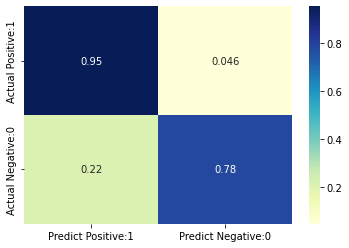

False Positive rate:  0.22  Out of all wrong preds, what % was positive?
False Negative rate:  0.05  Out of all wrong preds, what % was negative?
Specificity:  0.78  Out of all ppl who didn't recieve referals, what % was correct?
Sensitivity:  0.95  Out of all ppl who did receive referals, what % was correct?


array([11379,  3137,  1085, 22430])

In [ ]:
#baseline rf performance
rnd_forest = pd.DataFrame(columns=["Baseline", "Feature_Sel", "Feature_Sel_ns", "Feature_Sel_ngeo"],
                          index = ["accuracy", "precision","auc","recall","f1" ])

# instantiate classifier with default hyperparameters
rfc=RandomForestClassifier() 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(rfc, X, y, cv=k)
end = time.perf_counter()
rnd_forest["Baseline"] = my_scores(rfc,X,y)
print("TIME:",(end-start)/60,"min")

my_cm_dec(y, y_pred)

-----------------Random Forest-----------------


NotFittedError: ignored

In [ ]:
from sklearn.feature_selection import RFECV

selAcc = RFECV(RandomForestClassifier(), scoring='accuracy')
#add precision, f1, roc_auc, recall
selAcc.fit(X,y)
selAcc.score(X,y)

0.9983171623149536

In [ ]:
selPrec = RFECV(RandomForestClassifier(), scoring='precision')
selPrec.fit(X,y)
selPrec.score(X,y)

0.9951618416554916

In [ ]:
selFOne = RFECV(RandomForestClassifier(), scoring='f1')
selFOne.fit(X,y)
selFOne.score(X,y)

0.9994741132234229

In [ ]:
selRocAuc = RFECV(RandomForestClassifier(), scoring='roc_auc')
selRocAuc.fit(X,y)
selRocAuc.score(X,y)

1.0

In [ ]:
selRec = RFECV(RandomForestClassifier(), scoring='recall')
selRec.fit(X,y)
selRec.score(X,y)

0.9999737056611712

In [ ]:
for i, col in zip(range(X.shape[1]), X.columns):
  print(f"For Accuracy: {col} selected={selAcc.support_[i]} rank={selAcc.ranking_[i]}")
  print(f"For Precison: {col} selected={selPrec.support_[i]} rank={selPrec.ranking_[i]}")
  print(f"For F1: {col} selected={selFOne.support_[i]} rank={selFOne.ranking_[i]}")
  print(f"For RocAuc: {col} selected={selRocAuc.support_[i]} rank={selRocAuc.ranking_[i]}")
  print(f"For Recall: {col} selected={selRec.support_[i]} rank={selRec.ranking_[i]}")        

For Accuracy: st_AK selected=False rank=48
For Precison: st_AK selected=False rank=64
For F1: st_AK selected=False rank=28
For RocAuc: st_AK selected=True rank=1
For Recall: st_AK selected=True rank=1
For Accuracy: st_AL selected=True rank=1
For Precison: st_AL selected=False rank=12
For F1: st_AL selected=True rank=1
For RocAuc: st_AL selected=True rank=1
For Recall: st_AL selected=True rank=1
For Accuracy: st_AR selected=False rank=19
For Precison: st_AR selected=False rank=31
For F1: st_AR selected=True rank=1
For RocAuc: st_AR selected=True rank=1
For Recall: st_AR selected=True rank=1
For Accuracy: st_AZ selected=False rank=44
For Precison: st_AZ selected=False rank=59
For F1: st_AZ selected=False rank=25
For RocAuc: st_AZ selected=True rank=1
For Recall: st_AZ selected=True rank=1
For Accuracy: st_CA selected=True rank=1
For Precison: st_CA selected=True rank=1
For F1: st_CA selected=True rank=1
For RocAuc: st_CA selected=True rank=1
For Recall: st_CA selected=True rank=1
For Acc

In [ ]:
dataSelected = data.drop(columns=['st_AK','st_AL','st_AR','st_AZ','st_CA','st_CO','st_CT', 
                                  'st_DC', 'st_DE', 'st_FL', 'st_IN', 'st_HI', 'st_IA',
                                  'st_ID','st_IL','st_KS','st_KY', 'st_LA', 'st_MD', 'st_ME', 'st_MI', 'st_MN', 'st_MO',
                                  'st_MS', 'st_MT', 'st_NC', 'st_ND', 'st_NE', 'st_NH', 'st_NJ', 'st_NM', 'st_NV', 'st_NY', 'st_OH',
                                  'st_OK', 'st_OR', 'st_PA', 'st_PR', 'st_RI', 'st_SC', 'st_SD', 'st_TN', 'st_UT', 'st_VA', 'st_VT',
                                  'st_WA', 'st_WI', 'st_WV', 'st_WY','outcmfcs_yes', 'amiakn_yes', 'asian_no', 'asian_yes',
                                  'hawaiipi_no', 'hawaiipi_yes','raceunkn_no','raceunkn_yes', 'educaid_no', 'pubfinas_no',
                                  'pubfinas_not applicable','pubfoodas_no', 'pubfoodas_not applicable', 'children_yes',
                                  'marriage_no', 'marriage_yes', 'medicaid_do not know', 'othrhlthin_not applicable', 
                                  'othrhlthin_yes', 'medicalin_no', 'medicalin_yes', 'medicalin_do not know', 'mentlhlthin_do not know',
                                  'mentlhlthin_no', 'mentlhlthin_not applicable', 'mentlhlthin_yes', 'prescripin_no',
                                  'prescripin_not applicable', 'prescripin_do not know', 'prescripin_yes', 'baseline_yes'], axis=1)